# LOCAL DATA


### Step 1 — Tools for spatial data and representation analysis

We begin by importing libraries for:
- raster data (satellite images)
- numerical computation
- visualization
- unsupervised learning

This mirrors a real environmental ML workflow:
we combine GIS tools (rasterio) with ML tools (scikit-learn).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import rasterio
from rasterio.enums import Resampling

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


### Step 2 — Discovering the available satellite bands

Satellite images are multi-band data.
Before analysis, we must know:
- which bands are available
- how many spectral channels we have

This is always the first step when working with real EO data.


In [7]:
ROOT = Path("/workspaces/EnvDataScience-guide")
band_dir = ROOT / "data/environmental_data_week2/open-geo-tutorial-master/data/sentinel-2"


bands = sorted(band_dir.glob("*.tiff"))

print("Found bands:", len(bands))
for b in bands:
    print(" -", b.name)


Found bands: 8
 - 2018-10-13, Sentinel-2B L1C, B01.tiff
 - 2018-10-13, Sentinel-2B L1C, B02.tiff
 - 2018-10-13, Sentinel-2B L1C, B03.tiff
 - 2018-10-13, Sentinel-2B L1C, B04.tiff
 - 2018-10-13, Sentinel-2B L1C, B05.tiff
 - 2018-10-13, Sentinel-2B L1C, B06.tiff
 - 2018-10-13, Sentinel-2B L1C, B07.tiff
 - 2018-10-13, Sentinel-2B L1C, B08.tiff


- Sentinel-2 provides multiple spectral channels. 
- ML models do not see “images”. They see tensors with channels
- In Deep Learning (DL) this corresponds to checking : input_channels = 4 # or 8 or 13

### Step 3 — Reading raster bands and controlling resolution

Satellite images can be very large.
To work efficiently on CPU, we downsample the data.

This step teaches two important ideas:
1. ML models operate on arrays, not files
2. Resolution and memory always matter in EO


In [ ]:
def read_band(path, out_shape=None):
    with rasterio.open(path) as src:
        if out_shape is None:
            arr = src.read(1).astype("float32")
            profile = src.profile
        else:
            arr = src.read(
                1,
                out_shape=out_shape,
                resampling=Resampling.bilinear
            ).astype("float32")
            profile = src.profile.copy()
            profile.update(height=out_shape[0], width=out_shape[1])
    return arr, profile

b02 = [p for p in bands if "B02" in p.name][0]  # blue
b03 = [p for p in bands if "B03" in p.name][0]  # green
b04 = [p for p in bands if "B04" in p.name][0]  # red
b08 = [p for p in bands if "B08" in p.name][0]  # nir

# Downsample (CPU-friendly). Try 512x512 first.
out_shape = (512, 512)

blue, prof = read_band(b02, out_shape)
green, _ = read_band(b03, out_shape)
red, _ = read_band(b04, out_shape)
nir, _ = read_band(b08, out_shape)

print("Shape:", blue.shape)


Shape: (512, 512)


- We are working with a 512 × 512 spatial grid
- Each pixel still represents a real place on Earth
- In DL this corresponds to: resizing images; extracting manageable tiles ; choosing patch sizes

### Step 4 — Technical interpretation vs model input

RGB visualization is for the environmental scientist understanding. \
Models do not “see” RGB (they see numbers.)

We visualize the image to:
- verify correctness
- relate numerical values to land cover patterns


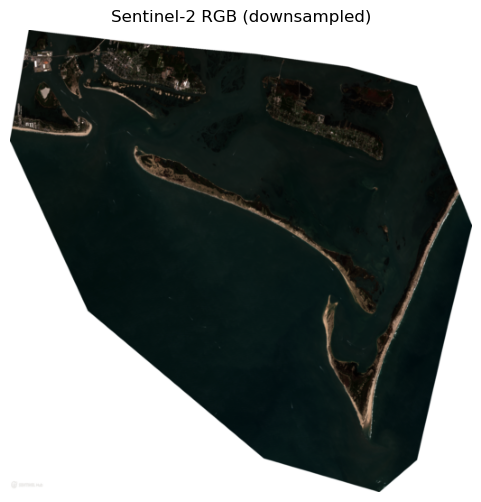

In [9]:
def normalize01(x):
    x = x.copy()
    x = x - np.nanmin(x)
    x = x / (np.nanmax(x) + 1e-6)
    return x

rgb = np.dstack([normalize01(red), normalize01(green), normalize01(blue)])

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.title("Sentinel-2 RGB (downsampled)")
plt.axis("off")
plt.show()


In the image you should recognize, vegetation, water, land boundaries. 
- For DL this step is not required, but essential for environmental scientist to trust the data. 

### Step 5 — Classical feature engineering (NDVI)

NDVI is a handcrafted feature designed by scientists.
It compresses spectral information into a single value related to vegetation.

This represents how EO analysis was traditionally done before deep learning.


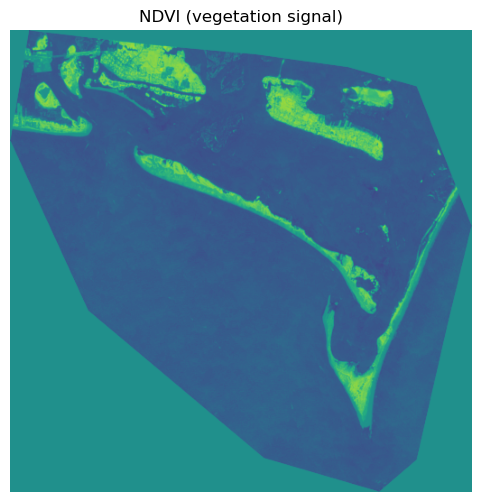

NDVI stats: -0.5932203531265259 0.7656903862953186


In [10]:
ndvi = (nir - red) / (nir + red + 1e-6)

plt.figure(figsize=(6,6))
plt.imshow(ndvi, vmin=-1, vmax=1)
plt.title("NDVI (vegetation signal)")
plt.axis("off")
plt.show()

print("NDVI stats:", float(np.nanmin(ndvi)), float(np.nanmax(ndvi)))


NDVI map shows:

- high values → vegetation
- low/negative → water or built areas

NDVI is a mnual feature. In DL, foundational models learn many NDVI-like features automatically.

### Step 6 — Capturing spatial context (texture)

Single pixels are ambiguous.
Environmental meaning comes from neighborhoods.

Here we compute a simple texture measure:
how much a pixel differs from its neighbors.

This approximates what convolutional filters learn automatically.


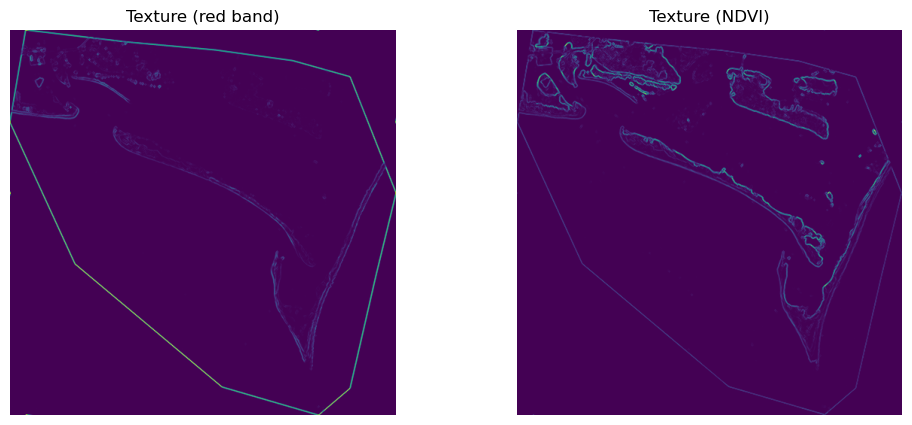

In [11]:
# Lightweight local variance using shifts (no scipy)
def local_variance(x):
    shifts = [
        x,
        np.roll(x, 1, 0), np.roll(x, -1, 0),
        np.roll(x, 1, 1), np.roll(x, -1, 1),
    ]
    m = sum(shifts) / len(shifts)
    v = sum((s - m)**2 for s in shifts) / len(shifts)
    return v

texture_red = local_variance(red)
texture_ndvi = local_variance(ndvi)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(texture_red)
plt.title("Texture (red band)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(texture_ndvi)
plt.title("Texture (NDVI)")
plt.axis("off")
plt.show()


From the above image, bright areas:

- edges
- boundaries
- transitions (shorelines, vegetation borders)

This is a manual proxy for convolution.
CNNs learn hundreds of such spatial filters

### Step 7 — Constructing a representation per pixel

We now stack all information into a single tensor.

Each pixel is represented by:
- spectral information
- vegetation signal
- spatial texture

This is NOT a learned embedding.
It is a manually constructed representation used for teaching.


In [12]:
H, W = red.shape

X = np.stack([
    blue, green, red, nir,
    ndvi,
    texture_red,
    texture_ndvi
], axis=-1)  # (H, W, D)

D = X.shape[-1]
X2 = X.reshape(-1, D)

print("Embedding tensor shape:", X.shape, "=> flattened:", X2.shape)


Embedding tensor shape: (512, 512, 7) => flattened: (262144, 7)


Meaning:

- H = 512, W = 512
- D = 7 features per pixel

Flattened:
262,144 pixels × 7 features

In foundation models:
- pixels/patches → D = 256–1024 learned features
- same idea, richer representation

### Step 8 — Understanding representation space with PCA

Representations live in high-dimensional space.
We cannot visualize them directly.

PCA projects the representation to 3 dimensions for visualization.
This does NOT train a model — it helps us understand structure.


Explained variance: [0.634 0.186 0.116]


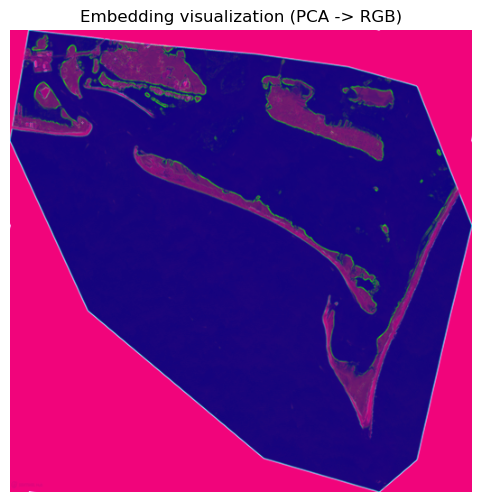

In [13]:
# Standardize features (important!)
scaler = StandardScaler()
X2s = scaler.fit_transform(X2)

# PCA to 3 dimensions to visualize (like projecting embeddings)
pca = PCA(n_components=3, random_state=42)
E3 = pca.fit_transform(X2s)  # (N, 3)

print("Explained variance:", pca.explained_variance_ratio_.round(3))

# Turn PCA components into an image
Eimg = E3.reshape(H, W, 3)

# Normalize per-channel for display
Edisp = np.dstack([normalize01(Eimg[...,i]) for i in range(3)])

plt.figure(figsize=(6,6))
plt.imshow(Edisp)
plt.title("Embedding visualization (PCA -> RGB)")
plt.axis("off")
plt.show()


The PCA RGB image shows:

- regions with similar representations
- spatial coherence without labels

Explained variance (63% + 18% + 11%) means that most information is captured in just a few directions

### Step 9 — Discovering land patterns without labels

We now cluster pixels using their representations.
No land-cover map is used.

This demonstrates how foundation model embeddings can be used
without supervision.


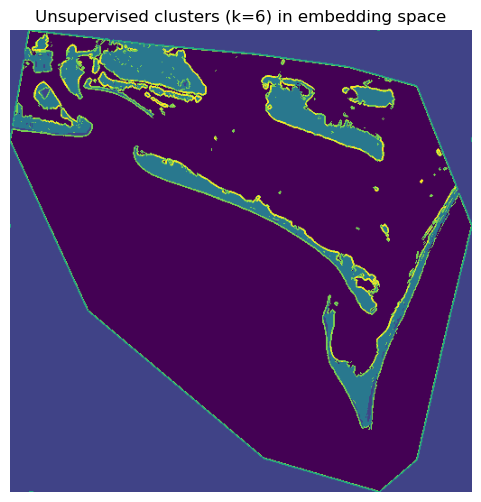

In [14]:
# Sample pixels for faster clustering fit (still maps back later)
rng = np.random.default_rng(42)
N = X2s.shape[0]
idx = rng.choice(N, size=min(40000, N), replace=False)

k = 6  # try 5-8 for teaching
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X2s[idx])

labels = kmeans.predict(X2s).reshape(H, W)

plt.figure(figsize=(6,6))
plt.imshow(labels)
plt.title(f"Unsupervised clusters (k={k}) in embedding space")
plt.axis("off")
plt.show()


Clusters correspond to:

- vegetation
- water
- sand
- built areas

In DL this is exactly how embeddings are user for:

- unsupervised mapping
- pseudo-labeling
- data exploration

### Step 10 — Are the results spatially meaningful?

Environmental patterns are spatially coherent.
Random clusters would be noisy.

We measure how often neighboring pixels share the same cluster.


In [17]:
def neighbor_agreement(L):
    agree = 0
    total = 0
    for shift in [(1,0), (-1,0), (0,1), (0,-1)]:
        Ls = np.roll(L, shift=shift, axis=(0,1))
        agree += (L == Ls).mean()
        total += 1
    return agree / total

score = neighbor_agreement(labels)
print("Spatial coherence (neighbor agreement):", round(float(score), 3))


Spatial coherence (neighbor agreement): 0.958


Meaning:

- clusters are spatially consistent
- representations respect geography

In DL this validates that embeddings encode spatial structure, not noise.

### Step 11 — Interpreting clusters using environmental knowledge

Clusters alone are abstract.
We interpret them using NDVI — a known environmental signal.

This is how scientists connect ML outputs to real meaning.


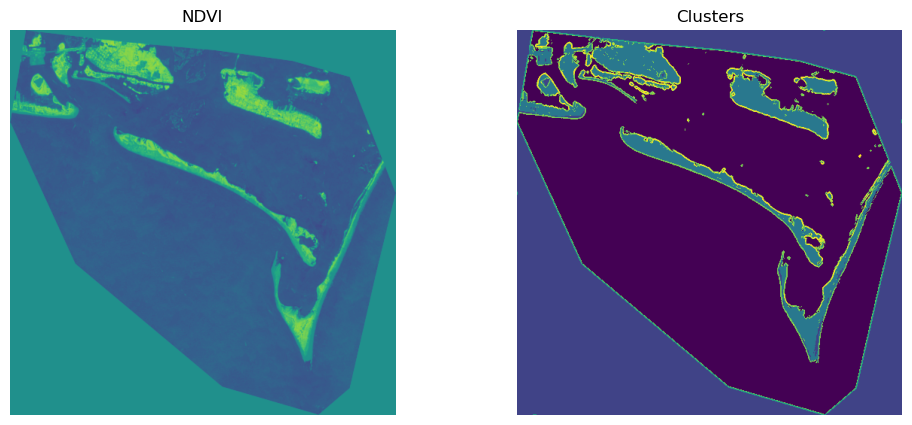

Cluster mean NDVI (higher = greener):
  cluster 2: mean NDVI = 0.372
  cluster 5: mean NDVI = 0.026
  cluster 1: mean NDVI = 0.000
  cluster 3: mean NDVI = -0.053
  cluster 4: mean NDVI = -0.103
  cluster 0: mean NDVI = -0.413


In [16]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(ndvi, vmin=-1, vmax=1)
plt.title("NDVI")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(labels)
plt.title("Clusters")
plt.axis("off")

plt.show()

# Summarize clusters by mean NDVI
means = []
for c in range(k):
    means.append((c, float(ndvi[labels==c].mean())))
means_sorted = sorted(means, key=lambda x: x[1], reverse=True)
print("Cluster mean NDVI (higher = greener):")
for c, m in means_sorted:
    print(f"  cluster {c}: mean NDVI = {m:.3f}")


Clusters with higher mean NDVI → vegetation
Lower → water / built areas

In DL this is representation → interpretation → decision.